In [1]:
"""
source: https://github.com/LauraGomezNavarro/OceanParcels_Lyapunov/blob/main/code/FTLE_func_test.py
Author: Main code by Laura Gomez Navarro adapted by Darshika Manral
"""
from math import sin, cos, sqrt, atan2, radians
import numpy as np
import xarray as xr
import numpy.linalg as LA
from datetime import timedelta, date
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib import colors
from progressbar import progressbar
import multiprocessing
import sys


In [17]:
model_mask_file = '/storage/shared/oceanparcels/input_data/NEMO16_CMCC/GLOB16L98_mesh_mask_atlantic.nc'

mask_ds = xr.open_dataset(model_mask_file, decode_times=False).load()
mask_lon = mask_ds['glamf'].values
mask_lat = mask_ds['gphif'].values
mask_land = mask_ds['tmask'].values[:,:,:,:]

In [15]:
home_folder = '/nethome/manra003/analysis/dispersion/'
mon_name ='Dec'
year=2017
r_depth=0
status=0
if status == 0:
    s = '2D'
elif status == 1:
    s = '3D'

asc_order='Bkwd'

ds=xr.open_zarr('/nethome/manra003/analysis/dispersion/simulations/Test_Bkwd_2D_Benguela_0625_401x257_Dec01-31_2017_0z.zarr')
# ds = xr.open_zarr(home_folder + 'simulations/{0}_{1}_Benguela_0625_401x257_{2}01-31_{3}_{4}z.zarr'.format(asc_order, s, mon_name, year, r_depth))

ds

<xarray.Dataset>
Dimensions:     (trajectory: 5596, obs: 16)
Coordinates:
  * obs         (obs) int32 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
  * trajectory  (trajectory) int64 0 1 2 3 4 5 ... 5590 5591 5592 5593 5594 5595
Data variables:
    lat         (trajectory, obs) float64 dask.array<chunksize=(5596, 1), meta=np.ndarray>
    lon         (trajectory, obs) float64 dask.array<chunksize=(5596, 1), meta=np.ndarray>
    time        (trajectory, obs) datetime64[ns] dask.array<chunksize=(5596, 1), meta=np.ndarray>
    z           (trajectory, obs) float64 dask.array<chunksize=(5596, 1), meta=np.ndarray>
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_mesh:           spherical
    parcels_version:        v2.4.1-265-g9573623b

In [3]:
def ftle_brunton_2009(J, Td):  # http://cwrowley.princeton.edu/papers/BruntonChaos09.pdf
    D = np.dot(np.transpose(J), J)  # Cauchy–Green strain tensor
    lamda = LA.eigvals(D)
    lam_max = max(lamda)
    ftle = (1 / Td) * np.log(np.sqrt(lam_max))
    return ftle


def dist_pairs_km(inlon1, inlon2, inlat1, inlat2):
    """
    source: https://stackoverflow.com/questions/19412462/getting-distance-between-two-points-based-on-latitude-longitude

    """
    # approximate radius of earth in km
    R = 6373.0

    lon1 = radians(inlon1)
    lat1 = radians(inlat1)
    lon2 = radians(inlon2)
    lat2 = radians(inlat2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c

    return distance

In [9]:
def reshape_locations(loc, mask):
    reshaped_array = np.empty((mask.shape))  # Create an empty 2D array
    reshaped_array[:]=np.NAN
    
    # Iterate through the mask and assign locations to reshaped array
    index = 0
    for i in range(mask.shape[0]):
        for j in range(mask.shape[1]):
            if mask[i][j]:
                reshaped_array[i][j] = loc[index]
                index += 1
    
    return reshaped_array

In [13]:
grid_lons.values[0]

array([17.      , 17.015625, 17.03125 , ..., 17.109375, 17.125   ,
       17.140625])

In [21]:
Td=15
output_folder = home_folder+ 'outputs/ftle/'
mask=np.load('/nethome/manra003/analysis/dispersion/Benguela_CroppedTestMask.npy') #129x65
out_index = Td # output everyday

grid_lons, grid_lats=np.array(ds['lon'][:, 0]), np.array(ds['lat'][:, 0])

# initial position
x0 = reshape_locations(ds['lon'][:, 0].values, mask)
y0 = reshape_locations(ds['lat'][:, 0].values, mask)

# final position
x1 = reshape_locations(ds['lon'][:, out_index].values, mask)
y1 = reshape_locations(ds['lat'][:, out_index].values, mask)

H = x0.shape[0]
L = x1.shape[1]

FTLE_f = np.ones_like(np.asarray(x0))
FTLE_f[:,:] = np.NaN

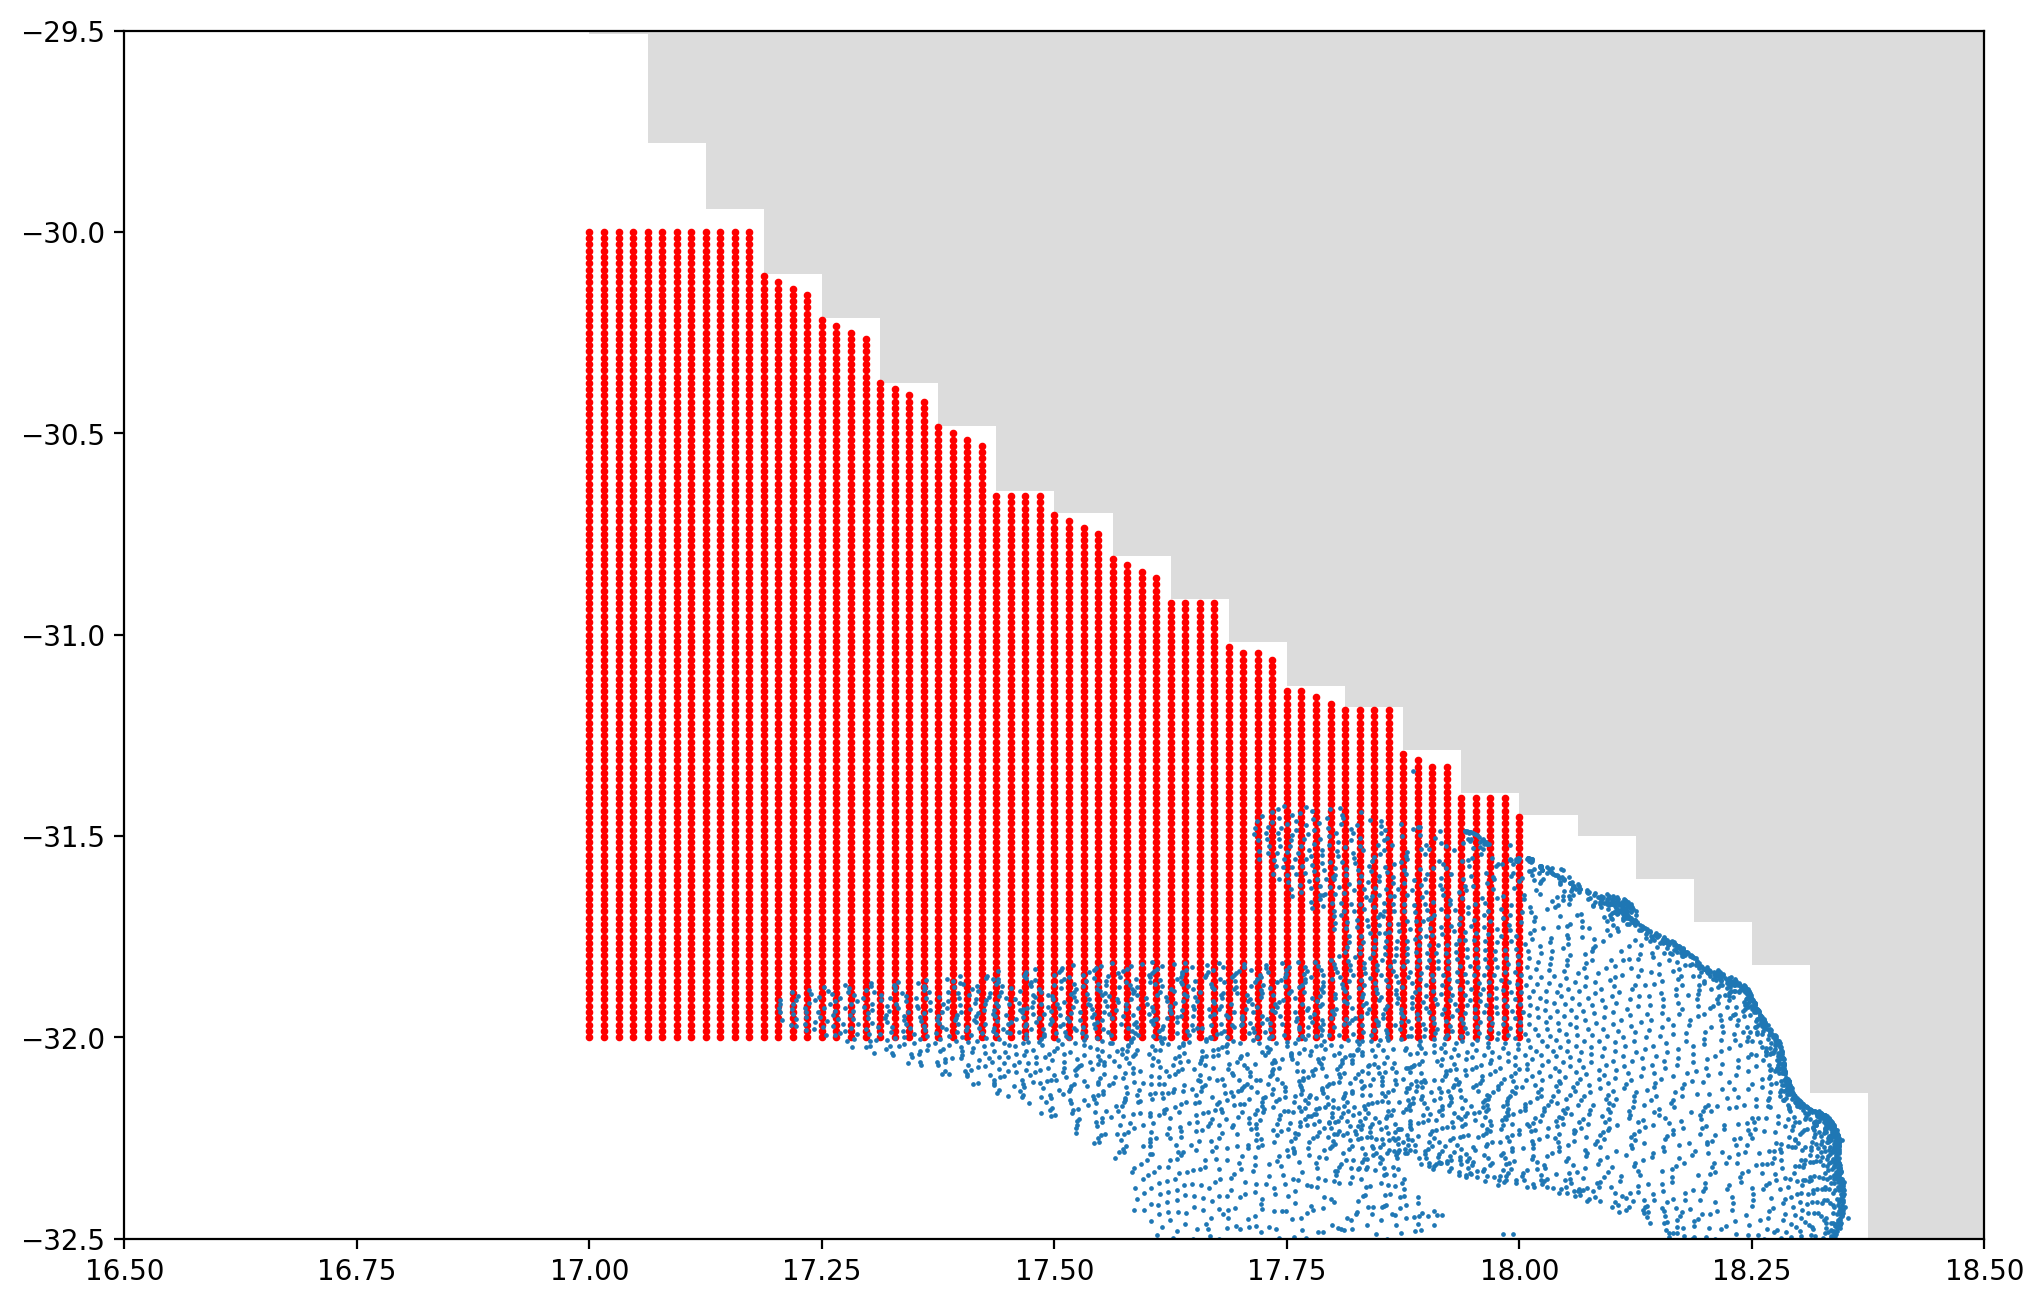

In [22]:
fig = plt.figure(figsize=(12,8), dpi=200)
ax = plt.axes()
colormap = colors.ListedColormap(['gainsboro', 'white'])

# Near Amazon river- 4-5 month simulations
ax.pcolormesh(mask_lon[0, 1249:1750, 1499:], mask_lat[0, 1249:1750, 1499:], mask_land[0, 0, 1250:1750, 1500:], cmap=colormap)

ax.set_xlim(16.5,18.5)
ax.set_ylim(-32.5,-29.5)
ax.scatter(x0, y0, s=3, c='red')
ax.scatter(x1, y1, s=0.5)

plt.show()

In [38]:
J = np.empty([2, 2], float)

# 1, H-1 --> to ignore bordersx for now
for i in progressbar(range(1, H - 1)):  # 0, H-2
    for j in range(1, L - 1):  # 0, L-2
        # pool = multiprocessing.Pool()
        # pool = multiprocessing.Pool(processes=8)
        
        J [:,:] = np.NaN
        ls = np.array((x0[i, j], y0[i, j], 
                    x0[i - 1, j], y0[i - 1, j], 
                    x0[i, j - 1], y0[i, j - 1],
                    x0[i, j + 1], y0[i, j + 1],
                    x0[i + 1, j], y0[i + 1, j]))
        if np.isnan(ls).any():
            continue

        J[0][0] = dist_pairs_km(x1[i, j], x1[i - 1, j], y1[i, j], y1[i - 1, j]) / dist_pairs_km(x0[i, j], x0[i - 1, j],
                                                                                                y0[i, j], y0[i - 1, j])
        J[0][1] = dist_pairs_km(x1[i, j], x1[i, j - 1], y1[i, j], y1[i, j - 1]) / dist_pairs_km(x0[i, j], x0[i, j - 1],
                                                                                                y0[i, j], y0[i, j - 1])
        J[1][0] = dist_pairs_km(x1[i, j], x1[i, j + 1], y1[i, j], y1[i, j + 1]) / dist_pairs_km(x0[i, j], x0[i, j + 1],
                                                                                                y0[i, j], y0[i, j + 1])
        J[1][1] = dist_pairs_km(x1[i, j], x1[i + 1, j], y1[i, j], y1[i + 1, j]) / dist_pairs_km(x0[i, j], x0[i + 1, j],
                                                                                                y0[i, j], y0[i + 1, j])

        f_value = ftle_brunton_2009(J, Td)
        FTLE_f[i][j] = f_value
print(np.nanmin(FTLE_f), np.nanmax(FTLE_f))


100% (127 of 127) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


-0.05947788587448059 0.27827299235653363


(-32.5, -29.5)

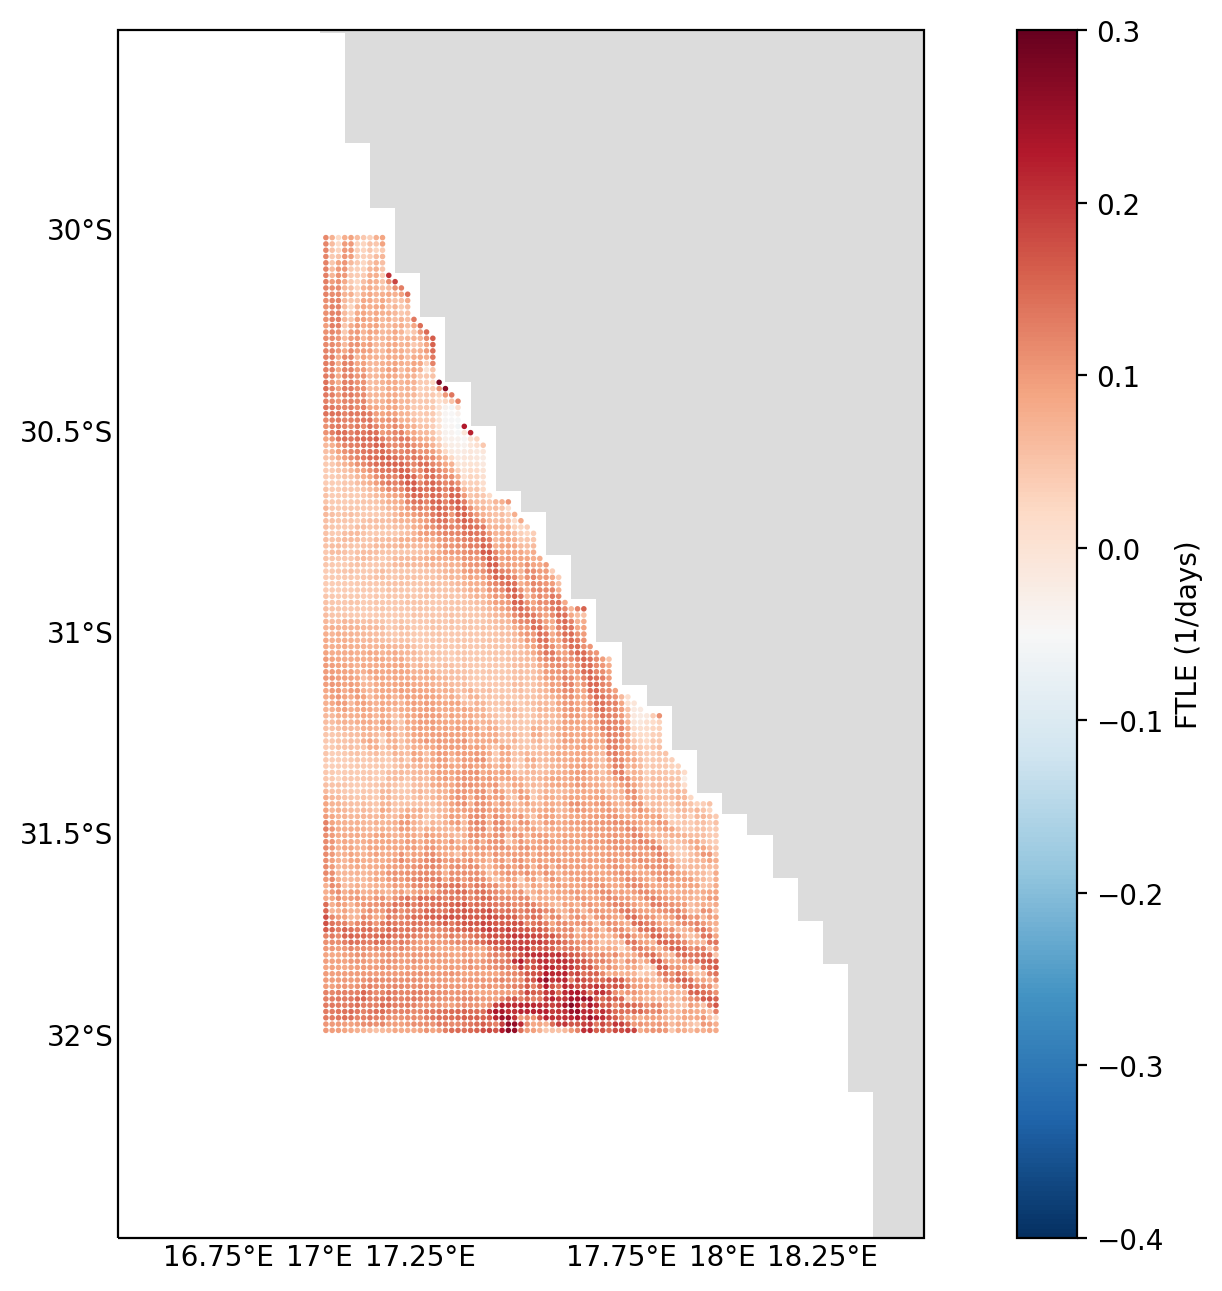

In [35]:
# left_lon = 17
# right_lon = 18
# top_lat = -30
# bottom_lat = -32

# delta = 0.0625/4

# lons = np.arange(left_lon, right_lon + delta, delta)
# lats = np.arange(bottom_lat, top_lat + delta, delta)
# regions_lons, regions_lats = np.meshgrid(lons, lats)
# print(regions_lons.shape)

custom_size=10
fig = plt.figure(figsize=(12,8), dpi=200)
ax = plt.axes(projection=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True)
gl.xlines = False
gl.ylines = False
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': custom_size, 'color': 'k'}
gl.ylabel_style = {'size': custom_size, 'color': 'k'}
ax.set_xlim(10, 20)
ax.set_ylim(-35, -20)
colormap = colors.ListedColormap(['gainsboro', 'white'])
ax.pcolormesh(mask_lon[0, 1249:1750, 1499:], mask_lat[0, 1249:1750, 1499:], mask_land[0, 0, 1250:1750, 1500:], cmap=colormap)

plt.scatter(regions_lons, regions_lats, c=FTLE_f, cmap='RdBu_r', s=1)
# plt.title('{6} {5} FLTE computation for {0} {1} after {4} days of release\n Minimum: {2} and Maximum: {3}'.format(mon_name, year, np.round(np.nanmin(FTLE_f),2), np.round(np.nanmax(FTLE_f),2), Td, dim, asc_order))
cbar = plt.colorbar()
cbar.set_label("FTLE (1/days)")
plt.clim(-0.4, 0.3)
ax.set_xlim(16.5,18.5)
ax.set_ylim(-32.5,-29.5)

In [6]:
np.min(ds_cropped.lat[:,0].values), np.max(ds_cropped.lat[:,0].values),np.min(ds_cropped.lon[:,0].values), np.max(ds_cropped.lon[:,0].values) 


(-34.9375, -20.0625, 10.0625, 19.9375)

In [4]:
coords0,coords1= (np.max(ds_cropped.lon[:,0].values) -np.min(ds_cropped.lon[:,0].values) )/0.0625 + 1, (np.max(ds_cropped.lat[:,0].values)-np.min(ds_cropped.lat[:,0].values))/0.0625 + 1
print(coords0,coords1)

159.0 239.0


In [5]:
grid_lons, grid_lats=ds_cropped['lon'][:, 0], ds_cropped['lat'][:, 0]
grid_lats.shape, grid_lons.shape

((38001,), (38001,))

In [21]:
# export grid lons and grid lats
np.savez('/nethome/manra003/analysis/dispersion/' + 'Benguela_0625_159x239_lat_lon.npz', lat = grid_lats, lon = grid_lons)

In [6]:
Td=15
# initial position
x0 = np.reshape(ds_cropped['lon'][:, 0].data, (coords0, coords1)) 
y0 = np.reshape(ds_cropped['lat'][:, 0].data, (coords0, coords1))

# final position

x1 = np.reshape(ds_cropped['lon'][:, Td].data, (coords0, coords1))
y1 = np.reshape(ds_cropped['lat'][:, Td].data, (coords0, coords1))

H = x0.shape[0]
L = x1.shape[1]

FTLE_f = np.ones_like(np.asarray(x0))
FTLE_f[:,:] = np.NaN

J = np.empty([2, 2], float)


In [7]:
x1.shape

(159, 239)

In [ ]:
#Export the FTLE to output file
output_folder = home_folder+ 'outputs/ftle/'
savename = output_folder + '{0}_{1}_Benguela_0625_401x257_{2}01-31_{2}_{3}z.npz'.format(s,asc_order,mon_name, year, d)

np.savez(savename, FTLE_f=FTLE_f)